# NYC Airbnb listing price regression

In [1]:
# Utilities and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Needed for coding
%matplotlib inline
%config IPCompleter.use_jedi = False

# Models and metrics
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import OneHotEncoder

In [3]:
dev_file = "development.csv"
eval_file = "evaluation.csv"

In [4]:
df_dev = pd.read_csv(dev_file)
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,NaN,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


## Data exploration and Pre-processing

In [5]:
df_dev.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

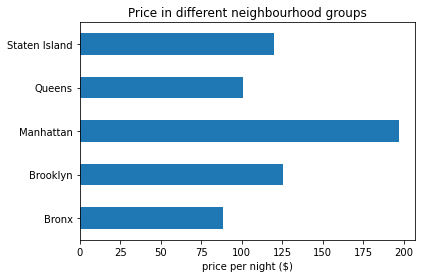

In [6]:
df_dev.groupby("neighbourhood_group")["price"].mean().plot(kind = 'barh')
plt.xlabel("price per night ($)")
plt.ylabel("")
plt.title("Price in different neighbourhood groups");

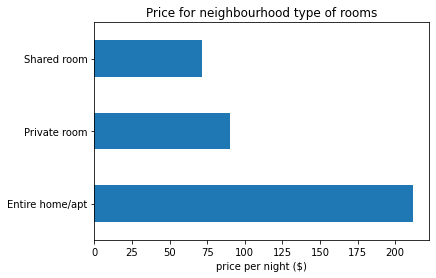

In [159]:
df_dev.groupby("room_type")["price"].mean().plot(kind = 'barh')
plt.xlabel("price per night ($)")
plt.ylabel("")
plt.title("Price for neighbourhood type of rooms");

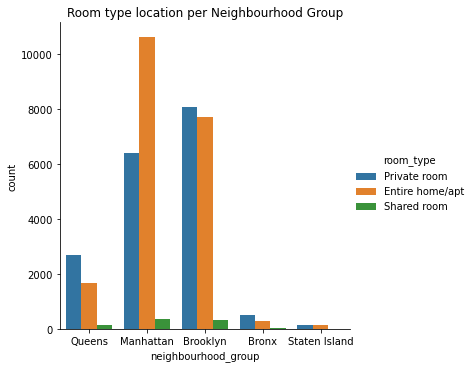

In [160]:
title = 'Room type location per Neighbourhood Group'
sb.catplot(x='neighbourhood_group', kind="count", hue="room_type", data=df_dev);
plt.title(title);

In [161]:
df_dev.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

#### Possible interesting features are:
- 'neighbourhood_group'
- 'room_type'
- 'minimum_nights',
- 'reviews_per_month'
- 'calculated_host_listings_count'

## Target values

In [162]:
df_dev.price.describe()

count    39116.000000
mean       153.406995
std        242.218222
min          0.000000
25%         69.000000
50%        108.000000
75%        178.000000
max      10000.000000
Name: price, dtype: float64

In [7]:
mask = df_dev.price == 0
df_dev.drop(df_dev[mask].index).price.describe()

count    39106.000000
mean       153.446223
std        242.236765
min         10.000000
25%         69.000000
50%        108.000000
75%        178.000000
max      10000.000000
Name: price, dtype: float64

In [8]:
df_dev.drop(df_dev[mask].index, inplace=True)

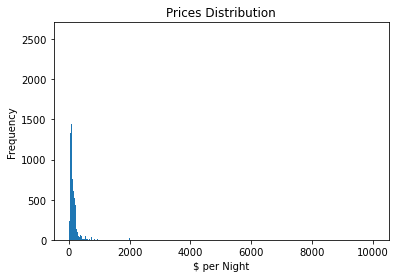

In [165]:
df_dev.price.plot(kind = 'hist', bins = 'fd');
plt.title("Prices Distribution")
plt.xlabel("$ per Night");

In [166]:
df_dev.price.describe()

count    39106.000000
mean       153.446223
std        242.236765
min         10.000000
25%         69.000000
50%        108.000000
75%        178.000000
max      10000.000000
Name: price, dtype: float64

### Handling missing values

In [167]:
df_dev.isna().sum()

id                                   0
name                                13
host_id                              0
host_name                           19
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8040
reviews_per_month                 8040
calculated_host_listings_count       0
availability_365                     0
dtype: int64

We are not interested in host name and place name, so we will leave them out.  
__Instead number of reviews per month are interesting features__:

In [9]:
mask = df_dev.number_of_reviews == 0
df_dev.loc[mask, "reviews_per_month"] = 0

In [169]:
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,0.00,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


## Numerical Attributes

### Minimum nights stay

In [170]:
q = 99.95
stay_q = np.percentile(df_dev.minimum_nights, q)

In [171]:
mask = df_dev.minimum_nights > stay_q
df_dev.drop(df_dev[mask].index).minimum_nights.describe()

count    39097.000000
mean         6.886462
std         16.655844
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        365.000000
Name: minimum_nights, dtype: float64

In [172]:
df_dev.drop(df_dev[mask].index, inplace=True)

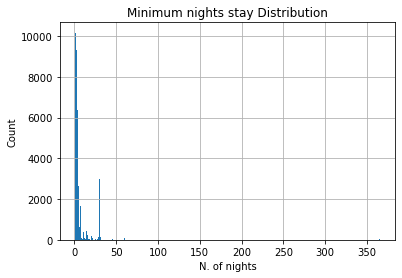

In [173]:
df_dev.minimum_nights.hist(bins = 365);
plt.title("Minimum nights stay Distribution")
plt.xlabel("N. of nights")
plt.ylabel("Count");

In [177]:
df_dev.minimum_nights.describe()

count    39097.000000
mean         6.886462
std         16.655844
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        365.000000
Name: minimum_nights, dtype: float64

In [178]:
df_dev.minimum_nights = pd.cut(df_dev.minimum_nights, bins = [0,1,3,5,30,500], labels= [1,3,5,30,100], duplicates= 'drop')

In [10]:
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,0.00,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


### Monthly reviews

In [180]:
df_dev.reviews_per_month.describe()

count    39097.000000
mean         1.093549
std          1.600048
min          0.000000
25%          0.040000
50%          0.370000
75%          1.590000
max         58.500000
Name: reviews_per_month, dtype: float64

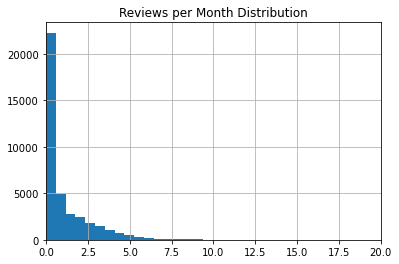

In [181]:
df_dev.reviews_per_month.hist(bins = 100)
plt.xlim((0,20))
plt.title("Reviews per Month Distribution");

__More than half do'nt have any monthly review__ !!  
I don't have much hope from this feature.

In [182]:
df_dev.reviews_per_month = pd.qcut(df_dev.reviews_per_month, q = [0,.75, .95, 1], labels= [1.6,5,10])

In [11]:
#df_dev = pd.get_dummies(df_dev, columns= ["reviews_per_month"],prefix="rpm", drop_first=True)
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,0.00,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


### Host Listings count

In [184]:
df_dev.calculated_host_listings_count.describe()

count    39097.000000
mean         7.206921
std         33.117574
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

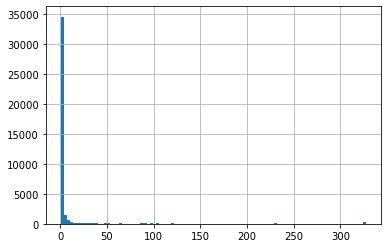

In [185]:
df_dev.calculated_host_listings_count.hist(bins = 100);

In [186]:
df_dev.calculated_host_listings_count = pd.cut(df_dev.calculated_host_listings_count, bins= [0,11,200,328], labels= [1,125,250])
df_dev.calculated_host_listings_count.value_counts()

1      36797
125     1847
250      453
Name: calculated_host_listings_count, dtype: int64

In [187]:
df_dev.availability_365.describe()

count    39097.000000
mean       112.916362
std        131.556827
min          0.000000
25%          0.000000
50%         46.000000
75%        226.000000
max        365.000000
Name: availability_365, dtype: float64

In [188]:
df_dev.availability_365 = pd.cut(df_dev.availability_365, bins = [-0.1,2,100,200,366], labels= [0,75,200,300] ,)
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,1.6,1,300
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,5.0,1,300
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,3,0,NaN,1.6,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,3,4,2019-07-07,5.0,1,75
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,1.6,1,200


## Catagorical Attributes and their encoding

### neighbourhood group

In [189]:
df_dev.neighbourhood_group.value_counts()

Manhattan        17355
Brooklyn         16063
Queens            4509
Bronx              873
Staten Island      297
Name: neighbourhood_group, dtype: int64

### Room type

In [190]:
df_dev.room_type.value_counts()

Entire home/apt    20409
Private room       17779
Shared room          909
Name: room_type, dtype: int64

In [12]:
df_dev = pd.get_dummies(df_dev, columns=["room_type", "neighbourhood_group"], drop_first= True)
df_dev.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Elmhurst,40.74037,-73.88610,75,1,2,2019-05-26,0.92,3,351,1,0,0,0,1,0
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Upper East Side,40.76717,-73.95532,95,1,202,2019-05-27,3.31,2,263,1,0,0,1,0,0
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Upper East Side,40.77984,-73.94725,130,2,0,NaN,0.00,1,0,0,0,0,1,0,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Bushwick,40.70205,-73.91338,150,2,4,2019-07-07,1.64,1,89,0,0,1,0,0,0
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Fort Greene,40.68914,-73.97853,325,3,16,2019-04-20,0.42,1,103,0,0,1,0,0,0


In [192]:
df_dev_large = pd.get_dummies(df_dev, columns= ["neighbourhood"], drop_first=True)
df_dev_large.head(5)

,id,name,host_id,host_name,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,...,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside
0,12783632,NYC Mini Hotel,57230304,Imanuelly,40.74037,-73.88610,75,1,2,2019-05-26,...,0,0,0,0,0,0,0,0,0,0
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,40.76717,-73.95532,95,1,202,2019-05-27,...,0,0,0,0,0,0,0,0,0,0
2,17572926,Great 1 Bedroom on Upper East,36578169,James,40.77984,-73.94725,130,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,40.70205,-73.91338,150,3,4,2019-07-07,...,0,0,0,0,0,0,0,0,0,0
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,40.68914,-73.97853,325,3,16,2019-04-20,...,0,0,0,0,0,0,0,0,0,0


## Model Building

### Feature selection

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [14]:
def select_features(X_train, y_train, X_test, k = 'all'):
    np.seterr(divide='ignore', invalid='ignore')
    
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k= k)
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    # transform train input data
    X_train_fs = fs.transform(X_train)
    
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [15]:
def make_train_test(df, test_size = 0.2, rs = None):
    X = df.iloc[:,1:].values
    y = df.iloc[:,0].values
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, shuffle = True, random_state = 99)
    return train_test_split(X, y, test_size= test_size, shuffle = True, random_state = rs)

In [16]:
def model_evalutation(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rep = f"""
    Model R2 score: {r2:.2f}
    Model MSE: {mse:.2f}
    """
    print(rep)
    
    # Create a Dataframe to compare values
    df = pd.DataFrame(data = {"True": y_test, "Predicted":y_pred})
    
    return df

In [17]:
exclude = ['id', 'name', 'host_id', 'host_name', 'last_review','number_of_reviews']
df = df_dev.drop(exclude, axis=1)
if "neighbourhood" in df.columns:
    df = df.drop(["neighbourhood"], axis = 1)
    
# arrange price to be first column
cols = list(df.columns)
cols[2], cols[0] = cols[0], cols[2]
df = df.loc[df.price < np.percentile(df.price, 99.999999),cols]
df.head()

,price,longitude,latitude,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,75,-73.88610,40.74037,1,0.92,3,351,1,0,0,0,1,0
1,95,-73.95532,40.76717,1,3.31,2,263,1,0,0,1,0,0
2,130,-73.94725,40.77984,2,0.00,1,0,0,0,0,1,0,0
3,150,-73.91338,40.70205,2,1.64,1,89,0,0,1,0,0,0
4,325,-73.97853,40.68914,3,0.42,1,103,0,0,1,0,0,0


Feature 6: 2135.790737
Feature 9: 953.437285
Feature 0: 838.022096
Feature 8: 328.862694
Feature 5: 254.439838
Feature 10: 242.462813
Feature 4: 105.368690
Feature 3: 98.407088
Feature 7: 92.706406
Feature 2: 29.417545
Feature 1: 28.827663
Feature 11: 2.733302


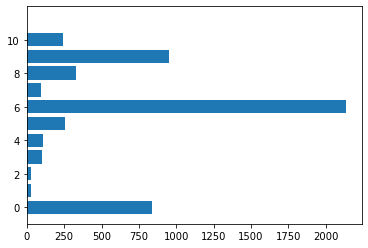

In [19]:
X_train, X_test, y_train, y_test = make_train_test(df, rs=909)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k = 'all')

# what are scores for the features
for i in np.argsort(fs.scores_)[::-1]:
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.barh(np.arange(fs.scores_.size), fs.scores_)
plt.show()

### Simple LinearRegression

In [20]:
reg = LinearRegression()
reg.fit(X_train_fs, y_train)
y_hat = reg.predict(X_test_fs)

model_evalutation(y_test, y_hat)


    Model R2 score: 0.11
    Model MSE: 47559.99
    


,True,Predicted
0,150,264.925643
1,225,182.180931
2,220,282.704022
3,159,199.006549
4,165,235.189326
...,...,...
7816,100,207.417346
7817,99,144.702735
7818,85,183.464888
7819,60,43.217932


### RandomForest Regressor

In [21]:
def make_model(reg, params, X_train, y_train,scoring, cv = 5):
    grid_search = GridSearchCV(reg,cv = cv, param_grid=params, scoring = scoring)
    grid_search.fit(X_train, y_train)
    print("Best combination of Parameters:")
    print(grid_search.best_params_)
    print(f"Best {scoring} Score:{grid_search.best_score_}")
    return grid_search.best_estimator_

In [22]:
reg = RandomForestRegressor(n_jobs=-1)
RF_params = {
    "n_estimators": np.array(range(10, 101, 20)),
    "max_depth": [10, 15, None],
   "max_features": ["auto", "sqrt"],
    "min_impurity_decrease": [0.0, 0.01]
}
best_RF_reg = make_model(reg, RF_params, X_train_fs, y_train, scoring="r2")

Best combination of Parameters:
{'max_depth': 15, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'n_estimators': 90}
Best r2 Score:0.1823161727744009


In [23]:
y_hat = best_RF_reg.predict(X_test_fs)
model_evalutation(y_test, y_hat)


    Model R2 score: 0.22
    Model MSE: 41872.77
    


,True,Predicted
0,150,152.721061
1,225,207.588961
2,220,231.420284
3,159,142.640512
4,165,203.942572
...,...,...
7816,100,191.898721
7817,99,170.762773
7818,85,209.401875
7819,60,70.968813


### KNeighbors Regressor

In [203]:
reg = KNeighborsRegressor(n_jobs=-1)
KNN_params = {
    "n_neighbors": np.array(range(10,51,10)),
    "weights": ["uniform", "distance"],
}
best_KNN_reg = make_model(reg,KNN_params, X_train_fs,  y_train, scoring="r2")

Best combination of Parameters:
{'n_neighbors': 50, 'weights': 'distance'}
Best r2 Score:0.5346891099384588


In [204]:
y_hat = best_KNN_reg.predict(X_test_fs)
model_evalutation(y_test, y_hat)


    Model R2 score: 0.54
    Model MSE: 1557.38
    


,True,Predicted
0,74,109.036088
1,40,74.366680
2,124,87.811137
3,200,144.935731
4,180,157.751719
...,...,...
7029,103,123.623710
7030,100,78.913919
7031,220,175.221349
7032,110,151.614332


### Support Vector Regressor

In [24]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [25]:
reg = make_pipeline(StandardScaler(), SVR(tol = 0.1))
reg.fit(X_train_fs, y_train)
y_hat = reg.predict(X_test_fs)

model_evalutation(y_test, y_hat)


    Model R2 score: 0.08
    Model MSE: 49007.94
    


,True,Predicted
0,150,178.573818
1,225,151.903905
2,220,186.851670
3,159,145.270977
4,165,191.297623
...,...,...
7816,100,154.580161
7817,99,159.624880
7818,85,92.830364
7819,60,56.558558
